In [46]:
%pip install llama-index-multi-modal-llms-gemini -q
%pip install llama-index-vector-stores-qdrant -q
%pip install llama-index-llms-gemini -q

!pip install llama-index 'google-generativeai>=0.3.0' matplotlib qdrant_client -q

In [ ]:
%pip install llama-index-embeddings-huggingface
%pip install llama-index-embeddings-instructor

In [ ]:
%pip install llama_index ftfy regex tqdm  -q
%pip install -U openai-whisper -q                     #convert audio to text by openai
%pip install git+https://github.com/openai/CLIP.git   # used to create embedding for images
%pip install torch torchvision -q
%pip install matplotlib scikit-image -q
%pip install lancedb -q                               #Multi modal vectordb
%pip install moviepy -q                               #library for video editing
%pip install pytube -q                                #to download youtube video
%pip install pydub  -q                                #Manipulate audio with an simple and easy high level interface.
%pip install SpeechRecognition -q
%pip install ffmpeg-python -q
%pip install soundfile -q

!pip install llama-index-readers-file -q

**Creating necessary folders in local**

In [34]:
video_url="https://youtu.be/3dhcmeOTZ_Q"                            #Used just 3min linear regression video

video_folder  ="/content/video_data/"                               #downloaded video saved as input_vid.mp4
video_path = video_folder + "input_vid.mp4"

output_folder = "/content/mixed_data/"

audio_path = "/content/mixed_data/audio.mp3"                 #extract audio from video and save

**Data Preprocessing**

In [82]:
# class to plot images from the path

import os
from PIL import Image
import matplotlib.pyplot as plt

class Plot_Images:
    def __init__(self, path):
        self.path = path

    def plot(self):
        images_shown = 0
        plt.figure(figsize=(15, 10))

        for i, image in enumerate(self.path):
            if os.path.isfile(image):  # Checking if the path is a file
                images = Image.open(image)
                plt.subplot(2,3, i + 1)
                plt.imshow(images)

                images_shown += 1
                if images_shown >= 10:
                   break  # Exiting the loop if enough images are shown


In [56]:
# Class to download YouTube video and return Metadata

from pytube import YouTube

class Video:
    def __init__(self, url, folder):
        self.url = url
        self.folder = folder
        self.video = None
        self.error = None

        try:
            self.video = YouTube(self.url)
        except Exception as e:
            self.error = f"Error: {str(e)}"

    def download(self, filename="input_vid.mp4"):
        """
        Downloads the YouTube video
        """
        if self.video:
            try:
                self.video.streams.get_highest_resolution().download(
                    output_path=self.folder, filename=filename
                )
            except Exception as e:
                self.error = f"Error downloading video: {str(e)}"

    def metadata(self):
        """
        Retrieves metadata of the video
        """
        if self.video:
            metadata = {
                "Title": self.video.title,
                "Author": self.video.author,
                "Views": self.video.views,
                "Duration": str(self.video.length),
            }
            return metadata
        else:
            return {"Error": self.error or "Video object not initialized."}



In [27]:
from moviepy.editor import VideoFileClip
import os

class video_extract:
    def __init__(self, path, folder):
        self.path = path
        self.folder = folder
        self.clip = None
        self.error = None

        try:
            self.clip = VideoFileClip(self.path)
        except Exception as e:
            self.error = f"Error in extracting images from video: {str(e)}"

# class to extract images from video through FPS(Frame Per Second)

class image_from_video(video_extract):
    def __init__(self, path, folder):
        super().__init__(path, folder)

    def extract_images(self, fps=0.2):
        if self.clip:
            # Ensure the output folder exists
            os.makedirs(self.folder, exist_ok=True)

            output_path = os.path.join(self.folder, "frame%04d.png")
            self.clip.write_images_sequence(output_path, fps=fps)
        else:
            print("No video clip available. Check for errors.")


In [32]:
# class to download audio from video using wisper

class audio_from_video(video_extract):
    def __init__(self, path, folder):
        super().__init__(path, folder)

    def extract_audio(self):
        audio_file_path = os.path.join(self.folder, "audio.mp3")
        self.clip.audio.write_audiofile(audio_file_path, codec='libmp3lame')





In [39]:
# class to extract text from audio

import whisper
import os

class text_from_audio(video_extract):
    def __init__(self, path, folder):
        super().__init__(path, folder)

    def extract_text(self):
        try:
            model = whisper.load_model("base")

            audio_path = os.path.join(self.path)
            audio = whisper.load_audio(audio_path)
            audio = whisper.pad_or_trim(audio)

            mel = whisper.log_mel_spectrogram(audio).to(model.device)

            _, probs = model.detect_language(mel)
            detected_language = max(probs, key=probs.get)
            print(f"Detected language: {detected_language}")

            options = whisper.DecodingOptions()
            result = whisper.decode(model, mel, options)

            text = result.text
            return text
        except Exception as e:
            print(f"Error extracting text: {str(e)}")
            return ""

    def save_text(self):
        try:
            text = self.extract_text()
            with open(os.path.join(self.folder, "output_text.txt"), "w") as file:
                file.write(text)
                print("Text data saved to file")
                file.close()

        except Exception as e:
            print(f"Error saving text: {str(e)}")


**Execution**

In [ ]:
# Downloading Video from YouTube and getting metadata

# Create an instance of the Video class
video = Video(video_url, video_folder)
video.download()


In [57]:
metadata = video.metadata()
print(metadata)

{'Title': 'Linear Regression in 3 Minutes', 'Author': '3-Minute Data Science', 'Views': 7236, 'Duration': 234, 'Publish Date': datetime.datetime(2022, 9, 8, 0, 0)}


In [ ]:
# Extracting images from video

# Create an instance of the image_from_video class
image_from_video = image_from_video(video_path, output_folder)
image_from_video.extract_images()

In [ ]:
# Extracting audio from video
audio_extractor = audio_from_video(video_path, output_folder)
audio_extractor.extract_audio()

In [40]:
# Extracting text from audio using wisper
text_from_audio = text_from_audio(audio_path, output_folder)
text_data = text_from_audio.save_text()

Detected language: en
Text data saved to file


**VectorStore Index creation in LlamaIndex - and sava in qdrant Inmemory**

In [ ]:

# Import embedding model from hugging face
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
embed_model=HuggingFaceEmbedding(model_name="sentence-transformers/all-mpnet-base-v2")

In [50]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import SimpleDirectoryReader, StorageContext

import qdrant_client
from llama_index.core import SimpleDirectoryReader

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_mm_db")

# if you only need image_store for image retrieval,
# you can remove text_sotre
text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)

storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Load text and image documents from local folder
documents = SimpleDirectoryReader(output_folder).load_data()
# Create the MultiModal index
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
    embed_model =embed_model
)

100%|███████████████████████████████████████| 338M/338M [00:10<00:00, 34.6MiB/s]


In [51]:
#Here retriever_engine, Retrive from index/vectorsearch/Lancedb inmemory
# It provides top 5 text tretrival (similarity_top_k=5) and top 5 image retrival (image_similarity_top_k=5)

retriever_engine=index.as_retriever(similarity_top_k=5, image_similarity_top_k=5)

**Create Prompt template using llama_index.core**

In [58]:
#Convert video medata to json format, which will be passed to prompt template


import json
# Convert datetime object to string
metadata['Publish Date'] = metadata['Publish Date'].strftime('%Y-%m-%d %H:%M:%S')

# Convert dictionary to JSON format
metadata_json = json.dumps(metadata)

print(metadata_json)

{"Title": "Linear Regression in 3 Minutes", "Author": "3-Minute Data Science", "Views": 7236, "Duration": 234, "Publish Date": "2022-09-08 00:00:00"}


In [59]:
# Prompt

qa_tmpl_str=(
    "Given the provided information, including relevant images and retrieved context from the video, \
    accurately and precisely answer the query without any additional prior knowledge.\n"

    "---------------------\n"
    "Context: {context_str}\n"
    "Metadata for video: {metadata_str} \n"

    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)

**Function to separate retrived image and text to separate list**

In [62]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

def retrieve(retriever_engine, query_str):
    retrieval_results = retriever_engine.retrieve(query_str)

    retrieved_image = []
    retrieved_text = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=200)
            retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text


In [63]:
query_str = "what is a O'Reilly platform.?"
img, txt = retrieve(retriever_engine=retriever_engine, query_str=query_str)

**Node ID:** 6c9affe4-ab39-4b6e-b99b-04196bd37e3d<br>**Similarity:** 0.15688866073057944<br>**Text:** Lenny regression is a statistical technique for modeling the relationship between an output variable and one or more input variables. In layman's terms, think of it as fitting a line through some d...<br>

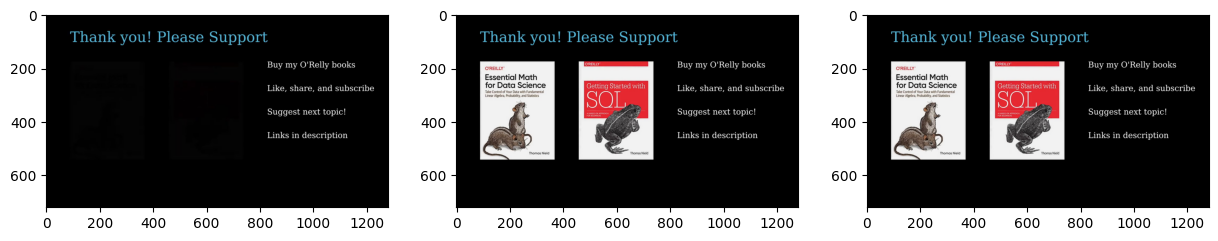

In [69]:
plot = Plot_Images(img)
plot.plot()

In [78]:
image_documents = SimpleDirectoryReader(input_dir=output_folder,  input_files=img).load_data()

**Initialize GeminiMultiModal**

In [76]:
#Access GOOGLE_API_KEY Key
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [77]:
from llama_index.multi_modal_llms.gemini import GeminiMultiModal

gemini_pro = GeminiMultiModal(model_name="models/gemini-pro-vision")

In [79]:
complete_response = gemini_pro.complete(
    #Pass the retrived text here in prompt template
    prompt=qa_tmpl_str.format(context_str="".join(txt),query_str=query_str, metadata_str=metadata_json),
    image_documents=image_documents,  #Pass the retrived images here
)

print(complete_response.text)

 The video is about Lenny regression, a statistical technique for modeling the relationship between an output variable and one or more input variables. The video does not mention anything about O'Reilly platform.


 The equation for a linear regression line is:

y = mx + b

where:

* y is the dependent variable
* x is the independent variable
* m is the slope of the line
* b is the y-intercept of the lineNone


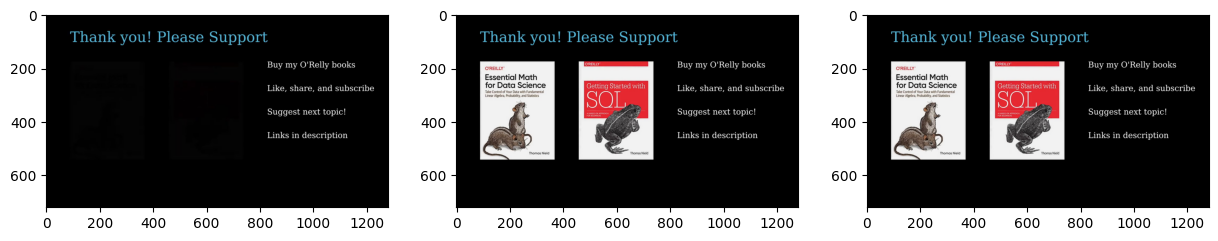

In [80]:
stream_complete_response = gemini_pro.stream_complete(
    prompt="what is Liner Regression formula?", #Here retrived context not passed only retrived image passed
    image_documents=image_documents,
)

for r in stream_complete_response:
    print(r.text, end="")

plot = Plot_Images(img)
print(plot.plot())

In [84]:
query_str="what is LLiner Regression formula?"

# Retrive from Lancedb based on user Q
img, txt = retrieve(retriever_engine=retriever_engine, query_str=query_str)

#Read retrived images from o/p corpus folder
image_documents = SimpleDirectoryReader(input_dir=output_folder,  input_files=img).load_data()

#Put retrived text to context_str
context_str = "".join(txt)

**Node ID:** 6c9affe4-ab39-4b6e-b99b-04196bd37e3d<br>**Similarity:** 0.5117173586757604<br>**Text:** Lenny regression is a statistical technique for modeling the relationship between an output variable and one or more input variables. In layman's terms, think of it as fitting a line through some d...<br>

In [86]:
#Complete a prompt with a bunch of images
complete_response = gemini_pro.complete(
    #Pass the retrived text here in prompt template
    prompt=qa_tmpl_str.format(context_str=context_str,query_str=query_str, metadata_str=metadata_json),
    image_documents=image_documents,  #Pass the retrived images here
)

print(complete_response)

 The equation for a linear regression line is f(x) = mx + b, where x is the input variable, y is the output variable, m is the slope of the line, and b is the y-intercept.


 A linear regression model is a statistical model that is used to predict the value of a continuous variable based on the values of one or more other variables. The model is represented by the equation `y = mx + b`, where `y` is the predicted value, `x` is the independent variable, `m` is the slope of the line, and `b` is the y-intercept.

Linear regression is a simple but powerful tool that can be used to make predictions about a wide variety of phenomena. For example, it can be used to predict the price of a house based on its square footage, the number of bedrooms and bathrooms, and the location of the house. It can also be used to predict the sales of a product based on the price of the product, the marketing campaign, and the economic conditions.

Linear regression is a valuable tool for businesses and organizations of all sizes. It can be used to make informed decisions about pricing, marketing, and other business decisions.None


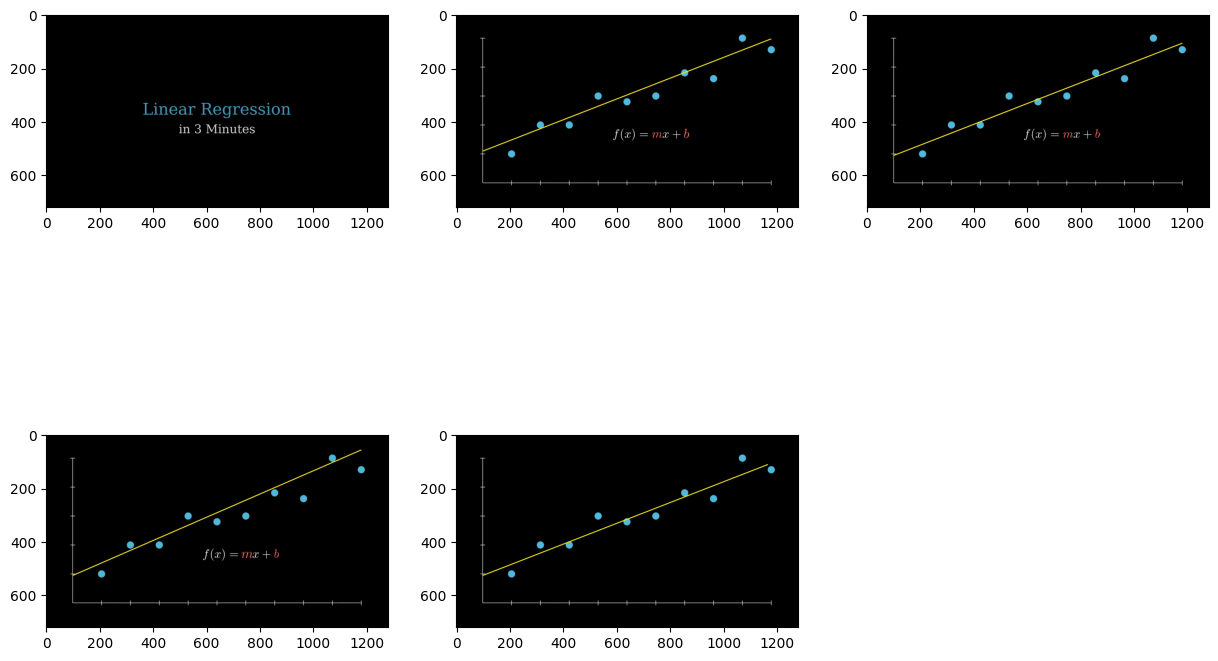

In [87]:
#Steam Complete a prompt with a bunch of images
stream_complete_response = gemini_pro.stream_complete(
    prompt="Give me more context for this image", #Here retrived context not passed only retrived image passed
    image_documents=image_documents,
)

for r in stream_complete_response:
    print(r.text, end="")

plot = Plot_Images(img)
print(plot.plot())